# Adaptive RAG (ARAG)
Description:
Adaptive RAG is a dynamic RAG framework that automatically selects the most appropriate retrieval strategy based on query complexity, ambiguity, or information needs. Instead of using a one-size-fits-all approach, it classifies queries and routes them through different retrieval paths.

Key Mechanism:
1. Query Classification: Analyzes the query to determine its type (simple, complex, ambiguous, multi-hop, etc.)
2. Strategy Selection: Chooses from multiple retrieval strategies:
3. Dynamic Execution: Executes the chosen strategy and generates the answer

Pros ✅
1. Performance Optimization
Reduced Latency: Avoids unnecessary retrieval for simple queries
Cost Efficiency: Fewer API calls for queries that don't need external context
Resource Management: Allocates computational resources based on need
2. Improved Accuracy
Tailored Retrieval: Uses the best strategy for each query type
Better Coverage: Complex queries get more comprehensive retrieval
Reduced Noise: Avoids irrelevant documents for straightforward questions
3. Flexibility & Adaptability
Handles Diverse Queries: From simple lookups to complex reasoning
Customizable Strategies: Can add/remove retrieval methods as needed
Learns from Feedback: Can incorporate user feedback to improve routing
4. Better User Experience
Faster Responses for simple queries
More Thorough Answers for complex queries
Transparent Process: Can explain why a particular strategy was chosen

Cons ❌
1. Increased Complexity
Multiple Systems: Maintains several retrieval strategies simultaneously
Routing Logic: Complex classification logic that needs careful tuning
Integration Overhead: More components to monitor and debug
2. Classification Errors
Misrouting Risk: Wrong strategy selection degrades performance
Threshold Tuning: Determining query complexity thresholds is non-trivial
Edge Cases: Ambiguous queries may be misclassified
3. Higher Development Cost
Multiple Implementations: Need to build/maintain several retrieval paths
Testing Complexity: Each strategy needs individual and integration testing
Documentation Burden: More complex system to document and maintain
4. Potential Inconsistency
Varying Answer Styles: Different strategies may produce different format
Unpredictable Behavior: Same query might get different strategies based on classification confidence
Debugging Difficulty: Harder to trace through multiple possible paths

In [1]:
from typing import List,Literal,TypedDict
from pydantic import BaseModel,Field
from langchain_core.documents import Document
from langchain_core.prompts import ChatPromptTemplate
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.chat_models import init_chat_model
from langchain_groq import ChatGroq
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.document_loaders import WebBaseLoader
from langgraph.prebuilt import create_react_agent 
import bs4
import os

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [2]:
# LLM Model 
llm = ChatGroq(model="openai/gpt-oss-120b",api_key=os.getenv("GROQ_API"))

# Normalizer
import re
def normalize_persian(text: str) -> str:
    text = text.replace("ي", "ی").replace("ك", "ک")
    text = re.sub(r"[^\w\s]", " ", text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()

# URLs
urls = [
    "https://parspack.com/blog/online-business/what-is-blog",
    "https://parspack.com/blog/online-business/seo-tutorial/what-is-keyword-mapping",
    "https://parspack.com/blog/os/linux/what-is-linux",
]

# Load documents
docs = []
for url in urls:
    loader = WebBaseLoader(
        url,
        bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
    docs.extend(loader.load())
    
# Normalize documents
for doc in docs:
    doc.page_content = normalize_persian(doc.page_content)
    
# Split documents
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,
    chunk_overlap=80,
    separators=["\n\n", "\n", ".", "؟", " "]
)
doc_splits = text_splitter.split_documents(docs)

# Embeddings
embedding_model = HuggingFaceEmbeddings(
    model_name="sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"
)

# Vector store
vectorstore = FAISS.from_documents(
    documents=doc_splits,
    embedding=embedding_model
)

# Retriever
retriever = vectorstore.as_retriever(
    search_type="similarity",
    search_kwargs={"k": 3}
)


In [16]:
## VectoreStore-Web Search router

# Data model
class RouteQuery(BaseModel):
    """Route a user query to the most relevant datasource."""

    datasource: Literal["vectorstore", "web_search"] = Field(
        ...,
        description="Given a user question choose to route it to web search or a vectorstore.",
    )

# LLM with function call
llm = ChatGroq(model="openai/gpt-oss-120b",api_key=os.getenv("GROQ_API"))
structured_llm_router = llm.with_structured_output(RouteQuery)

# Prompt
system = """You are an expert at routing a user question to a vectorstore or web search.
The vectorstore contains documents related to weblog creating, keyboard maping and SEO.
Use the vectorstore for questions on these topics. Otherwise, use web-search."""
route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)

question_router = route_prompt | structured_llm_router

print(
    question_router.invoke(
        {"question": "وبلاگ"}
    )
)


datasource='vectorstore'


In [4]:
print(question_router.invoke({"question": "لیست سینماهای تهران"}))

datasource='web_search'


In [5]:
## Retrieval Grader

# Data model
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )


# LLM with function call
llm = ChatGroq(model="openai/gpt-oss-120b",api_key=os.getenv("GROQ_API"))
structured_llm_grader = llm.with_structured_output(GradeDocuments)

# Prompt
system = """You are a grader assessing relevance of a retrieved document to a user question. \n 
    If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

retrieval_grader = grade_prompt | structured_llm_grader
question = "تاثیرات کلمات کلیدی در CEO"
## context
docs = retriever.invoke(question)
doc_txt = docs[1].page_content
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

binary_score='yes'


In [6]:
## Generate

from langchain_classic import hub
from langchain_core.output_parsers import StrOutputParser

# Prompt
prompt = hub.pull("rlm/rag-prompt")

# LLM
llm = ChatGroq(model="openai/gpt-oss-120b",api_key=os.getenv("GROQ_API"))

# Post-processing
def format_docs(docs=docs):
    return "\n\n".join(doc.page_content for doc in docs1)

# Chain
rag_chain = prompt | llm | StrOutputParser()

# Run
generation = rag_chain.invoke({"context": docs, "question": question})
print(generation)

کلمات کلیدی با به‌کارگیری نقشهٔ دقیق کلمات کلیدی می‌توانند موقعیت سایت را در نتایج جستجو ارتقا دهند و نرخ کلیک (CTR) را افزایش دهند. محتوای منطبق بر نیاز کاربر باعث افزایش زمان ماندن در صفحه و کاهش نرخ پرش می‌شود. علاوه بر این، جلوگیری از تولید محتوای تکراری و هدف‌گذاری دقیق باعث بهبود کلی استراتژی سئو می‌گردد.


In [7]:
## Hallucination Grader

# Data model
class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in generation answer."""

    binary_score: str = Field(
        description="Answer is grounded in the facts, 'yes' or 'no'"
    )

# LLM with function call
llm = ChatGroq(model="openai/gpt-oss-120b",api_key=os.getenv("GROQ_API"))
structured_llm_grader = llm.with_structured_output(GradeHallucinations)

# Prompt
system = """You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts. \n 
     Give a binary score 'yes' or 'no'. 'Yes' means that the answer is grounded in / supported by the set of facts."""
hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Set of facts: \n\n {documents} \n\n LLM generation: {generation}"),
    ]
)

hallucination_grader = hallucination_prompt | structured_llm_grader
hallucination_grader.invoke({"documents": docs, "generation": generation})

GradeHallucinations(binary_score='yes')

In [8]:
## Answer Grader

# Data model
class GradeAnswer(BaseModel):
    """Binary score to assess answer addresses question."""

    binary_score: str = Field(
        description="Answer addresses the question, 'yes' or 'no'"
    )


# LLM with function call
llm = ChatGroq(model="openai/gpt-oss-120b",api_key=os.getenv("GROQ_API"))
structured_llm_grader = llm.with_structured_output(GradeAnswer)

# Prompt
system = """You are a grader assessing whether an answer addresses / resolves a question \n 
     Give a binary score 'yes' or 'no'. Yes' means that the answer resolves the question."""
answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "User question: \n\n {question} \n\n LLM generation: {generation}"),
    ]
)

answer_grader = answer_prompt | structured_llm_grader
answer_grader.invoke({"question": question, "generation": generation})

GradeAnswer(binary_score='yes')

In [9]:
## Question Re-writer

# LLM
llm = ChatGroq(model="openai/gpt-oss-120b",api_key=os.getenv("GROQ_API"))

# Prompt
system = """You a question re-writer that converts an input question to a better version that is optimized \n 
     for vectorstore retrieval. Look at the input and try to reason about the underlying semantic intent / meaning.\n
     write it in one line.
     """
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)

question_rewriter = re_write_prompt | llm | StrOutputParser()
question_rewriter.invoke({"question": question})

'کلمات کلیدی چه تأثیری بر بهینه\u200cسازی موتورهای جستجو (SEO) دارند؟'

In [10]:
## Web-Search

from langchain_community.tools.tavily_search import TavilySearchResults
web_search_tool = TavilySearchResults(k=3)

C:\Users\user\AppData\Local\Temp\ipykernel_18148\1655306515.py:4: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  web_search_tool = TavilySearchResults(k=3)


In [11]:
class GraphState(TypedDict):
    question: str
    generation: str
    documents: List[str]

In [12]:
## Functions creating

def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}


def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]

    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}


def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            continue
    return {"documents": filtered_docs, "question": question}


def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    print("---TRANSFORM QUERY---")
    question = state["question"]
    documents = state["documents"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question}


def web_search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    print("---WEB SEARCH---")
    question = state["question"]

    # Web search
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)

    return {"documents": web_results, "question": question}


### Edges ###


def route_question(state):
    """
    Route question to web search or RAG.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    question = state["question"]
    source = question_router.invoke({"question": question})
    if source.datasource == "web_search":
        print("---ROUTE QUESTION TO WEB SEARCH---")
        return "web_search"
    elif source.datasource == "vectorstore":
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"


def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    state["question"]
    filtered_documents = state["documents"]

    if not filtered_documents:
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---"
        )
        return "transform_query"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"


def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    score = hallucination_grader.invoke(
        {"documents": documents, "generation": generation}
    )
    grade = score.binary_score

    # Check hallucination
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        score = answer_grader.invoke({"question": question, "generation": generation})
        grade = score.binary_score
        if grade == "yes":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        else:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
    else:
        print("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"

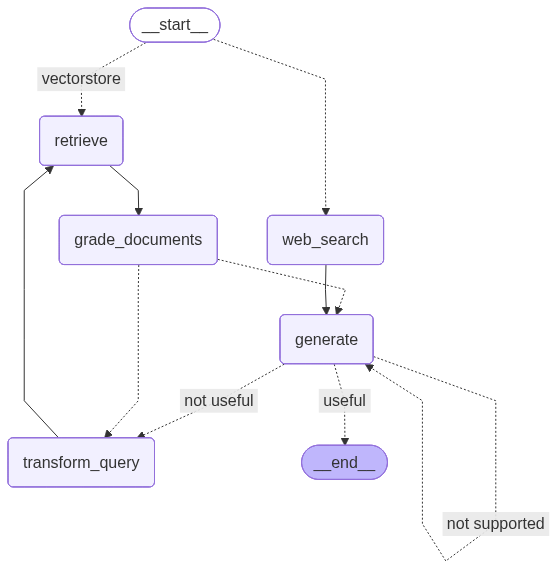

In [17]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("web_search", web_search)
workflow.add_node("retrieve", retrieve)
workflow.add_node("grade_documents", grade_documents)
workflow.add_node("generate", generate)
workflow.add_node("transform_query", transform_query)

# Build graph
workflow.add_conditional_edges(
    START,
    route_question,
    {
        "web_search": "web_search",
        "vectorstore": "retrieve",
    },
)
workflow.add_edge("web_search", "generate")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "retrieve")
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "transform_query",
    },
)

# Compile
app = workflow.compile()
app

In [14]:
app.invoke({"question":"فرق ماه های میلادی و شمسی چیه"})

---ROUTE QUESTION---
---ROUTE QUESTION TO WEB SEARCH---
---WEB SEARCH---
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---


{'question': 'فرق ماه های میلادی و شمسی چیه',
 'generation': 'ماه\u200cهای میلادی (تقویم گریگوری) از ژانویه تا دسامبر شامل ۱۲ ماه با طول ثابت ۲۸ تا ۳۱ روز هستند و سال جدید در ۱ ژانویه آغاز می\u200cشود. ماه\u200cهای شمسی (تقویم هجری‑شمسی ایران) نیز ۱۲ ماه دارند؛ شش ماه اول ۳۱ روز، پنج ماه بعدی ۳۰ روز و آخرین ماه (اسفند) ۲۹ روز (در سال\u200cهای کبیسه ۳۰ روز) و سال جدید حدود ۲۱ مارس شروع می\u200cشود. بنابراین تفاوت اصلی در ترتیب، طول ماه\u200cها و تاریخ شروع سال است.',
 'documents': Document(metadata={}, page_content='اطلاع از بازه زمانی ماه های میلادی و شمسی به شما کمک می\u200cکند تا راحت\u200cتر بتوانید ماه\u200c های میلادی را به تقویم ایرانی تبدیل کنید. به همین علت در این بخش ترتیب ماه های میلادی را برای شما ذکر کرده\u200cایم تا ببینید هر ماه میلادی به تقویم ایرانی چند روز است و از چه تاریخی آغاز شده و تا چه تاریخی ادامه دارد. [...] (معادل شمسی)، ماه های میلادی به عدد و... را در یک نگاه مشاهده می\u200cکنید. [...] در مطالب فوق در خصوص ماه های میلادی 2025 صحبت کردیم. یادگیری ماه های میلا

In [18]:
app.invoke({"question":"نکات ساخت یک وبلاگ یا وبسایت خوب"})

---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
---RETRIEVE---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---


{'question': 'نکات ساخت یک وبلاگ یا وبسایت خوب',
 'generation': 'برای ساخت یک وبلاگ یا وبسایت خوب ابتدا هدف خود را مشخص کنید؛ اگر می\u200cخواهید محتوا به\u200cصورت منظم و با زبان محاوره\u200cای منتشر شود، وبلاگ مناسب است، در غیر این\u200cصورت یک وبسایت ساختارمندتر انتخاب کنید. سپس سادگی مدیریت و دسترسی آسان را در نظر بگیرید و از پلتفرم\u200cهای کاربرپسند استفاده کنید تا بدون نیاز به تخصص فنی پیشرفته بتوانید محتوا را به\u200cروز کنید. در نهایت، محتوای با کیفیت، به\u200cروز و متنوع (متن، تصویر، ویدیو) را به\u200cصورت منظم منتشر کنید تا تعامل و حس صمیمیت با مخاطب ایجاد شود.',
 'documents': [Document(id='bfbeb0b3-16d8-4aab-9bd3-32db0e9e5c7c', metadata={'source': 'https://parspack.com/blog/online-business/what-is-blog'}, page_content='هر مطلب وجود دارد به صورت اختیاری است و معمولا در صفحات مقاله وب سایت دیده می شود بخش بندی بخشی از وب سایتی بزرگ است وب سایت صفحه ای در فضای وب است که احتمال دارد شامل وبلاگ نیز باشد راه اندازی و مدیریت نسبتا آسان است و به تخصص خاصی نیاز ندارد به مهارت های فنی

In [19]:
app.invoke({"question":"اون نکاتی که گفتی رو خلاصه تر بگو"})

---ROUTE QUESTION---


BadRequestError: Error code: 400 - {'error': {'message': 'Tool choice is required, but model did not call a tool', 'type': 'invalid_request_error', 'code': 'tool_use_failed', 'failed_generation': 'بله، حتماً! در ادامه نکات کلیدی را به\u200cصورت خلاصه\u200cوار برای هر سه موضوع (ایجاد وبلاگ، تنظیم کیبورد و سئو) آورده\u200cام:\n\n### ۱. ایجاد وبلاگ\n- **پلتفرم مناسب**: WordPress، Ghost یا Wix؛ بسته به نیاز به سفارشی\u200cسازی و سادگی استفاده.\n- **نام دامنه و میزبانی**: یک نام دامنه کوتاه و به\u200c یادماندنی انتخاب کنید؛ سرویس میزبانی با سرعت بالا و پشتیبانی خوب.\n- **طراحی واکنش\u200cگرا**: قالبی انتخاب کنید که در موبایل و دسکتاپ به\u200cخوبی نمایش داده شود.\n- **محتوا**: مقالات با کیفیت، عناوین جذاب و ساختار منطقی (H1‑H3) بنویسید.\n- **افزونه\u200cها**: برای سئو (Yoast/Rank Math)، امنیت (Wordfence) و سرعت (WP Rocket) افزونه\u200cهای معتبر نصب کنید.\n\n### ۲. تنظیم کیبورد (Keyboard Mapping)\n- **نقشه\u200cسازی کلیدها**: از نرم\u200cافزارهایی مثل AutoHotkey (Windows) یا Karabiner‑Elements (macOS) برای اختصاص عملکردهای دلخواه به کلیدها استفاده کنید.\n- **پروفایل\u200cهای مختلف**: برای برنامه\u200cهای خاص (IDE، مرورگر، بازی) پروفایل جداگانه بسازید تا سوئیچ کردن آسان باشد.\n- **کلیدهای ترکیبی**: ترکیب\u200cهای Ctrl\u202f+\u202fAlt\u202f+\u202f… یا Cmd\u202f+\u202fShift\u202f+\u202f… برای دسترسی سریع به دستورات پرکاربرد.\n- **آزمون و بهبود**: پس از تنظیم، چند روز استفاده کنید و بر اساس راحتی و کارایی، کلیدها را بازنگری کنید.\n\n### ۳. سئو (SEO)\n- **تحقیق کلیدواژه**: از ابزارهایی مثل Google Keyword Planner یا Ahrefs برای پیدا کردن کلمات کلیدی مرتبط و پرجستجو استفاده کنید.\n- **بهینه\u200cسازی داخل صفحه**: عنوان (title)، توضیح متا (meta description)، تگ\u200cهای H1‑H3، URL\u200cهای کوتاه و استفاده مناسب از کلیدواژه\u200cها.\n- **سرعت سایت**: تصاویر فشرده، کش مرورگر و CDN برای کاهش زمان بارگذاری.\n- **لینک\u200cسازی داخلی**: پیوندهای داخلی منطقی برای ارتقای ساختار سایت و افزایش زمان بازدید کاربران.\n- **محتوای ارزشمند**: مقالات طولانی (حداقل ۱۰۰۰ کلمه) با اطلاعات به\u200cروز، داده\u200cهای آماری و تصاویر مرتبط.\n- **سایت\u200cنقشه (Sitemap) و robots.txt**: برای کمک به ربات\u200cهای موتورهای جستجو در ایندکس صحیح صفحات.\n\nاین خلاصه\u200cها به\u200cصورت کلی هستند؛ اگر بخواهید جزئیات بیشتری در هر بخش داشته باشید، بگویید تا به\u200cطور دقیق\u200cتر بپردازیم.'}}

### as we encounter the error need to add memory to the graph

In [20]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()
config = {
    "configurable": {
        "thread_id": "rag-user-1"
    }
}


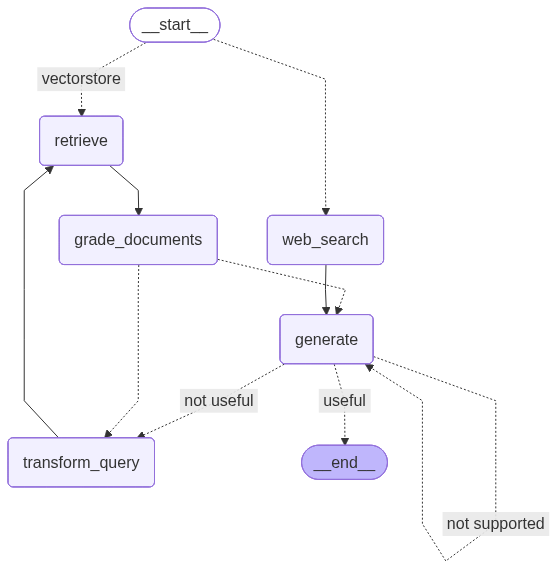

In [21]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("web_search", web_search)
workflow.add_node("retrieve", retrieve)
workflow.add_node("grade_documents", grade_documents)
workflow.add_node("generate", generate)
workflow.add_node("transform_query", transform_query)

# Build graph
workflow.add_conditional_edges(
    START,
    route_question,
    {
        "web_search": "web_search",
        "vectorstore": "retrieve",
    },
)
workflow.add_edge("web_search", "generate")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "retrieve")
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "transform_query",
    },
)

# Compile
app = workflow.compile(checkpointer=memory)
app

In [22]:
for event in app.stream({"question":"تفاوت ماه های شمسی و قمری چیست" },
                                   stream_mode="values",
                                   config=config):print(event)
    

---ROUTE QUESTION---
---ROUTE QUESTION TO WEB SEARCH---
{'question': 'تفاوت ماه های شمسی و قمری چیست'}
---WEB SEARCH---
{'question': 'تفاوت ماه های شمسی و قمری چیست', 'documents': Document(metadata={}, page_content='شما می توانید با کلیک بروی تقویم 98 به دانلود و فایل pdf تقویم شمسی سال پیش رو دسترسی داشته باشید.  \n 12 ماه قمری یک سال قمری را تشکیل می دهد. ماه قمری به معنای مدت زمانی است که طول می کشد تا ماه به اشکال مختلفی که می شناسیم ( ماه کامل، نیم قمر و هلال و دوباره ماه کامل) تغییر شکل دهد و به حالت ابتدایی بازگردد. ماه قمری 29.5 روز طول می کشد، هرچند تغییرات کوچکی نیز دارد اما به طور میانگین در همین بازه می ماند. [...] سال شمسی به مدت زمانی گفته می شود که طول می کشد تا زمین یک دور کامل به دور خورشید بچرخد. ماه شمسی نیز یک دوازدهم سال شمسی است. ماه های شمسی تقویم در تعداد روزها با یکدیگر تفاوت دارند و علت موضوع این است که 365 روز را که بر 12 ماه تقسیم کنیم 5 روز اضافه است و به همین دلیل برای قرار گرفتن کامل روزها در 12 ماه، 5 ماه 31 روزه داریم. [...] دانشمندان سال شمسی را بر اسا

In [23]:
for event in app.stream({"question":"خب چه ارتباطی با هجرت رسول اکرم داره"},
                                   stream_mode="values",
                                   config=config):print(event)

---ROUTE QUESTION---
---ROUTE QUESTION TO WEB SEARCH---
{'question': 'خب چه ارتباطی با هجرت رسول اکرم داره', 'generation': 'ماه\u200cهای شمسی بر پایهٔ گردش زمین به دور خورشید تعریف می\u200cشوند؛ هر ماه یک دوازدهم سال خورشیدی است و طول آن ۳۰ یا ۳۱ روز (سال ۳۶۵ روز) است. ماه\u200cهای قمری بر پایهٔ دورهٔ تغییر شکل ماه (هلال‑قمر‑کامل) هستند؛ هر ماه تقریباً ۲۹٫۵ روز طول می\u200cکشد و ۱۲ ماه مجموعاً حدود ۳۵۴ روز است. بنابراین سال شمسی حدود ۱۱ روز طولانی\u200cتر از سال قمری است.', 'documents': Document(metadata={}, page_content='شما می توانید با کلیک بروی تقویم 98 به دانلود و فایل pdf تقویم شمسی سال پیش رو دسترسی داشته باشید.  \n 12 ماه قمری یک سال قمری را تشکیل می دهد. ماه قمری به معنای مدت زمانی است که طول می کشد تا ماه به اشکال مختلفی که می شناسیم ( ماه کامل، نیم قمر و هلال و دوباره ماه کامل) تغییر شکل دهد و به حالت ابتدایی بازگردد. ماه قمری 29.5 روز طول می کشد، هرچند تغییرات کوچکی نیز دارد اما به طور میانگین در همین بازه می ماند. [...] سال شمسی به مدت زمانی گفته می شود که طول می کشد تا زم

### model stuck in re-write and retriever loop sometimes

**solution :** route re-writer to the beginning

In [24]:
def Starter (state):
    # print("hi")
    return print("hi")

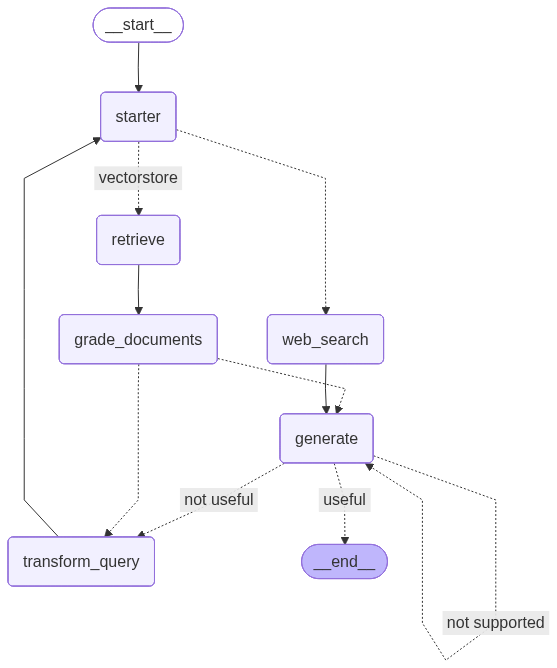

In [25]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("starter", Starter)
workflow.add_node("web_search", web_search)
workflow.add_node("retrieve", retrieve)
workflow.add_node("grade_documents", grade_documents)
workflow.add_node("generate", generate)
workflow.add_node("transform_query", transform_query)

# Build graph
workflow.add_edge(START,"starter")
workflow.add_conditional_edges(
    "starter",
    route_question,
    {
        "web_search": "web_search",
        "vectorstore": "retrieve",
    },
)
workflow.add_edge("web_search", "generate")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "starter")
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "transform_query",
    },
)

# Compile
app = workflow.compile(checkpointer=memory)
app

In [26]:
for event in app.stream({"question":"تفاوت ماه های شمسی و قمری چیست" },
                                   stream_mode="values",
                                   config=config):print(event)
    


{'question': 'تفاوت ماه های شمسی و قمری چیست', 'generation': 'علی بن ابی\u200cطالب نقش کلیدی در موفقیت هجرت پیامبر داشت؛ او با فریب قریش، بازگرداندن امانت\u200cها و همراهی با محمد (ص) به مکه رفت تا مسیر مهاجرت امن شود. این اقدامات او باعث شد که پیامبر بتواند به یثرب (مدینه) مهاجرت کند و حکومت اسلامی پایه\u200cگذاری شود. بنابراین، ارتباط مستقیم بین علی و هجرت رسول\u200cاکرم از طریق حمایت و فداکاری اوست.', 'documents': Document(metadata={}, page_content='هجرت رسول اکرم صلی الله علیه و آله از فرازهای حساس تاریخ اسلام است که حضرت علی علیه السلام در به نتیجه رسیدن آن نقش بسزایی داشته است. به همین دلیل، تاریخ نگاران شیعه و سنی وقتی هجرت رسول اکرم صلی الله علیه و آله را بررسی می کنند، با اشاره به نقش علی بن ابی طالب علیه السلام در این حادثه، به بارنشستن هدف های هجرت را مدیون جانبازی ایشان می دانند.\nبالا (و پیروز) است و خدا عزیز و حکیم است».  ۳.۵ - آیه مهاجرت«إِنَّ الَّذِينَ تَوَفَّاهُمُ الْمَلَائِكَةُ ظَالِمِي أَنفُسِهِمْ قَالُوا فِيمَ كُنتُمْ ۖ قَالُوا كُنَّا مُسْتَضْعَفِينَ فِي الْأَرْ\u20

In [27]:
for event in app.stream({"question":"گفتی مبدا آن هجرت رسول اکرم است این موضوع را خلاصه توضیح میدی"},
                                   stream_mode="values",
                                   config=config):print(event)
    


{'question': 'گفتی مبدا آن هجرت رسول اکرم است این موضوع را خلاصه توضیح میدی', 'generation': 'ماه\u200cهای شمسی بر پایهٔ گردش زمین به دور خورشید تعریف می\u200cشوند؛ هر ماه یک دوازدهم سال شمسی است و طول آن 30 یا 31 روز (سال 365 روز، هر چهار سال یک سال کبیسه 366 روز) است. ماه\u200cهای قمری بر پایهٔ دورهٔ تناوب ماه از هلال تا هلال (حدود 29٫5 روز) محاسبه می\u200cشوند؛ سال قمری 12 ماه تقریباً 354 روز دارد. بنابراین تفاوت اصلی طول هر ماه (30‑31 روز در شمسی vs حدود 29‑30 روز در قمری) و مجموع روزهای سال (365\u202fvs\u202f354، اختلاف حدود 11 روز) است.', 'documents': Document(metadata={}, page_content='شما می توانید با کلیک بروی تقویم 98 به دانلود و فایل pdf تقویم شمسی سال پیش رو دسترسی داشته باشید.  \n 12 ماه قمری یک سال قمری را تشکیل می دهد. ماه قمری به معنای مدت زمانی است که طول می کشد تا ماه به اشکال مختلفی که می شناسیم ( ماه کامل، نیم قمر و هلال و دوباره ماه کامل) تغییر شکل دهد و به حالت ابتدایی بازگردد. ماه قمری 29.5 روز طول می کشد، هرچند تغییرات کوچکی نیز دارد اما به طور میانگین در همین با

### Note that Tavily Search is not suitable for this kind of chat bot